<a href="https://colab.research.google.com/github/bernardo-martins/DisasterPredictor/blob/main/DisasterPredictor_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and other installations

In [187]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords
from transformers import RobertaTokenizerFast
import spacy
import string
nlp = spacy.load('en_core_web_sm')

!pip install nltk
!pip install spacy
!pip install gensim
!python -m spacy download en_core_web_sm
!pip install transformers

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [188]:
BATCH_SIZE = 16
LSTM_UNITS = 128
EMBEDDING_DIM = 100
MAX_LENGTH = 64

In [189]:
import zipfile
import os

def unzip_and_load_data(zip_file_path, extract_to='.'):
    """
    Unzips a file and returns a list of extracted file paths.

    :param zip_file_path: The path to the zip file.
    :param extract_to: The directory where the files will be extracted.
    :return: A list of paths to the extracted files.
    """
    extracted_files = []

    # Check if the zip file exists
    if not os.path.exists(zip_file_path):
        raise FileNotFoundError(f"The zip file {zip_file_path} does not exist.")

    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        extracted_files = zip_ref.namelist()

    # Return the list of extracted file paths
    extracted_file_paths = [os.path.join(extract_to, file) for file in extracted_files]

    return extracted_file_paths

def load_csv(file_path):
    """
    Loads a CSV file into a pandas DataFrame.

    :param file_path: The path to the CSV file.
    :return: A pandas DataFrame containing the CSV data.
    """
    return pd.read_csv(file_path)


In [190]:
def train_val_datasets(dataframe, labels_column):
    TRAINING_SPLIT = 0.9
    BATCH_SIZE = 128
    BUFFER_SIZE = 10000

    # Split the dataframe into features and labels
    features = dataframe.drop(labels_column, axis=1)
    labels = dataframe[labels_column]

    # Convert the DataFrame to a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((features.values, labels.values))

    # Shuffle the dataset
    dataset = dataset.shuffle(BUFFER_SIZE)

    total_size = len(dataframe)  # Use DataFrame length instead of dataset cardinality
    train_size = int(TRAINING_SPLIT * total_size)

    # Split into training and validation sets
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    # Batch the datasets
    train_dataset = train_dataset.batch(BATCH_SIZE)
    validation_dataset = validation_dataset.batch(BATCH_SIZE)

    return train_dataset, validation_dataset

In [191]:
zip_file = 'nlp-getting-started.zip'  # Specify the zip file path
extract_dir = './extracted_data'  # Specify where to extract the files

extracted_files = unzip_and_load_data(zip_file, extract_dir)
for file in extracted_files:
    if file.endswith('.csv'):
        df = load_csv(file)

In [192]:
# Extract only the necessary data
df = df[['text', 'target']]

In [193]:
# Create the train and validation datasets
train_dataset, validation_dataset = train_val_datasets(df, 'target')

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(validation_dataset)} batches for a total of {NUM_BATCHES*len(validation_dataset)} elements for validation.\n")

There are 54 batches for a total of 864 elements for training.

There are 6 batches for a total of 96 elements for validation.



Stop-words

In [194]:
def standardize(sentence):
  sentence = sentence.lower()

  sentence = remove_stopwords(sentence)

  return sentence

Vectorization

In [195]:
import tensorflow as tf

def fit_vectorizer(sentences):
    """
    Instantiates the TextVectorization layer and adapts it to the sentences.

    Args:
        sentences (list[str]): lower-cased sentences without stopwords

    Returns:
        tf.keras.layers.TextVectorization: an instance of the TextVectorization layer adapted to the texts.
    """

    tf.keras.utils.set_random_seed(65)  # Set random seed for reproducibility

    # Define the object
    vectorizer = tf.keras.layers.TextVectorization(
        standardize="lower_and_strip_punctuation",  # Use the defined function here
        ragged=True,  # Allow for variable-length sequences
        max_tokens=10000,  # Limit the vocabulary size
    )

    # Adapt it to the corpus
    vectorizer.adapt(sentences)

    return vectorizer

In [196]:
sentences = df['text'].astype(str).values
vectorizer = fit_vectorizer(sentences)

In [197]:
# Apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
validation_dataset_vectorized = validation_dataset.map(lambda x,y: (vectorizer(x), y))

In [198]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_sequences_padded = []
train_labels = []
validation_sequences_padded = []
validation_labels = []
dim = 100

for features, label in train_dataset_vectorized:
    # Convert features (which are tensors) to lists
    sequence = pad_sequences(features.numpy(), maxlen=dim, padding='post', dtype='float32')
    train_sequences_padded.append(sequence)  # Append the numpy array
    train_labels.append(label.numpy())
    assert sequence.shape[1] == dim

train_sequences_padded = np.array(train_sequences_padded[:-1])
train_labels = np.array(train_labels[:-1])

for features, label in validation_dataset_vectorized:
    # Convert features (which are tensors) to lists
    sequence = pad_sequences(features.numpy(), maxlen=dim, padding='post', dtype='float32')
    validation_sequences_padded.append(sequence)  # Append the numpy array
    validation_labels.append(label.numpy())
    assert sequence.shape[1] == dim

validation_sequences_padded = np.array(validation_sequences_padded[:-1])
validation_labels = np.array(validation_labels[:-1])

print(train_sequences_padded.shape)
print(train_labels.shape)
print("-----")
print(validation_sequences_padded.shape)
print(validation_labels.shape)

(53, 128, 100)
(53, 128)
-----
(5, 128, 100)
(5, 128)


Using pre-defined Embeddings

In [199]:
# Define path to file containing the embeddings
glove_file = 'glove.6B.100d.txt'
glove_embeddings = {}

with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs
word_index = {x:i for i,x in enumerate(vectorizer.get_vocabulary())}
vocab_size = vectorizer.vocabulary_size()

In [200]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None and not embedding_vector.shape[0] != EMBEDDING_DIM:
        embeddings_matrix[i] = embedding_vector


Create Model

In [241]:
def create_lstm_model():
    """
    Creates a binary sentiment classifier model using LSTM without the embedding layer,
    assuming input data is already pre-embedded.

    Returns:
        (tf.keras.Model): the sentiment classifier model
    """

    model = tf.keras.Sequential([
        # Input layer for sequences of embedded vectors (shape: 128 timesteps, 100-dimensional embedding)
        tf.keras.Input(shape=(128, 100)),

        # Dropout for regularization
        tf.keras.layers.Dropout(0.5),

        # Fully connected layer
        tf.keras.layers.Dense(64, activation='relu'),

        # Output layer for binary classification
        tf.keras.layers.Dense((1), activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [242]:
print("vocab_size: ",vocab_size)
print("embeddings_matrix: ",embeddings_matrix.shape)
print("train_sequences_padded: ",train_sequences_padded.shape)

model = create_lstm_model()
model.summary()

vocab_size:  10000
embeddings_matrix:  (10000, 100)
train_sequences_padded:  (53, 128, 100)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)                 │ (None, 128, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128, 64)             │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 128, 1)              │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,529 (25.50 KB)

 Trainable params: 6,529 (25.50 KB)

 Non-trainable params: 0 (0.00 B)

In [283]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_sequences_padded, validation_labels))

In [284]:
TRAIN_BATCH_SIZE = 32
VALIDATION_BATCH_SIZE = 32

In [285]:
train_dataset.cardinality()
train_dataset = train_dataset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)
validation_dataset = validation_dataset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)

In [296]:
tf.config.run_functions_eagerly(True)

history = model.fit(
	x= train_dataset,
	epochs=200,
  shuffle=True,
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5708 - loss: 6.6316
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5713 - loss: 6.5826
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5593 - loss: 6.8012
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5769 - loss: 6.5367
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5610 - loss: 6.7650
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.5645 - loss: 6.7067
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5771 - loss: 6.5305
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5708 - loss: 6.5744
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5659 - loss: 6.6684
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5667 - loss: 6.7133
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5769 - loss: 6.5384
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 

Accuracy: [0.57080078125, 0.5712890625, 0.559326171875, 0.576904296875, 0.56103515625, 0.564453125, 0.5771484375, 0.57080078125, 0.56591796875, 0.566650390625, 0.576904296875, 0.574951171875, 0.57177734375, 0.5693359375, 0.565673828125, 0.56591796875, 0.5732421875, 0.568603515625, 0.56005859375, 0.566162109375, 0.5634765625, 0.57080078125, 0.559326171875, 0.57470703125, 0.57080078125, 0.572509765625, 0.567626953125, 0.576904296875, 0.56640625, 0.564453125, 0.5595703125, 0.54638671875, 0.5751953125, 0.58203125, 0.566162109375, 0.569580078125, 0.57763671875, 0.57470703125, 0.565185546875, 0.56298828125, 0.56787109375, 0.5615234375, 0.571044921875, 0.576171875, 0.57421875, 0.563720703125, 0.56689453125, 0.572509765625, 0.570556640625, 0.56494140625, 0.55712890625, 0.562744140625, 0.5634765625, 0.556640625, 0.566650390625, 0.56591796875, 0.575927734375, 0.550537109375, 0.560791015625, 0.567626953125, 0.57177734375, 0.5693359375, 0.573974609375, 0.574951171875, 0.5771484375, 0.57177734375, 

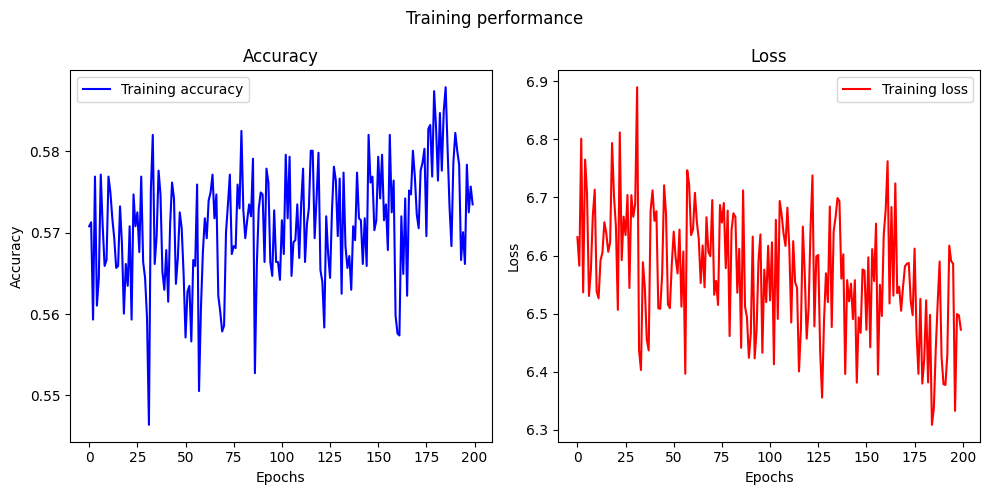

In [297]:
import matplotlib.pyplot as plt

# Get training accuracies and losses
acc = history.history['accuracy']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(acc))

# Print accuracy and loss values
print("Accuracy:", acc)
print("Loss:", loss)

# Plot the performance
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training performance')

# Plot Accuracy
ax[0].plot(epochs, acc, 'b', label='Training accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot Loss
ax[1].plot(epochs, loss, 'r', label='Training loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(train_sequences_padded, train_labels, verbose=False)

#predictions = model.predict(example_batch, verbose=False)
print(f"predictions have shape: {predictions.shape}")